This demo provides examples of `ImageReader` class from `niftynet.io.image_reader` module.

What is `ImageReader`?

The main functionality of `ImageReader` is to search a set of folders, return a list of image files, and load the images into memory in an iterative manner.

A `tf.data.Dataset` instance can be initialised from an `ImageReader`, this makes the module readily usable as an input op to many tensorflow-based applications.

Why `ImageReader`?

 - designed for medical imaging formats and applications 
 - works well with multi-modal input volumes
 - works well with `tf.data.Dataset`

## Before the demo...

First make sure the source code is available, and import the module.

For NiftyNet installation, please checkout:

http://niftynet.readthedocs.io/en/dev/installation.html

In [2]:
import sys
niftynet_path = '/data/weiwei/github/NiftyNet-1//'
sys.path.insert(0, niftynet_path)

from niftynet.io.image_reader import ImageReader

INFO:tensorflow:TensorFlow version 1.10.0
CRITICAL:tensorflow:Optional Python module cv2 not found, please install cv2 and retry if the application fails.
CRITICAL:tensorflow:Optional Python module skimage.io not found, please install skimage.io and retry if the application fails.
INFO:tensorflow:Available Image Loaders:
['nibabel', 'pillow', 'simpleitk', 'dummy'].
INFO:niftynet: Optional Python module yaml not found, please install yaml and retry if the application fails.
INFO:niftynet: Optional Python module yaml version None not found, please install yaml-None and retry if the application fails.
ssssitk <module 'SimpleITK' from '/home/weiwei/niftyEnv/lib/python3.5/site-packages/SimpleITK/__init__.py'>


For demonstration purpose we download some demo data to `~/niftynet/data/`:

In [ ]:
from niftynet.utilities.download import download
download('anisotropic_nets_brats_challenge_model_zoo_data')

## Use case: loading 3D volumes

In [ ]:
from niftynet.io.image_reader import ImageReader

data_param = {'nii': {'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/','filename_contains': 'label'}}
reader = ImageReader().initialise(data_param)

In [ ]:
reader.shapes, reader.tf_dtypes

In [ ]:
# read data using the initialised reader
idx, image_data, interp_order = reader(idx=0)

In [ ]:
image_data['MR'].shape, image_data['MR'].dtype

In [ ]:
# randomly sample the list of images
for _ in range(3):
    idx, image_data, _ = reader()
    print('{} image: {}'.format(idx, image_data['MR'].shape))

The images are always read into a 5D-array, representing:

`[height, width, depth, time, channels]`

## User case: loading pairs of image and label by matching filenames
(In this case the loaded arrays are not concatenated.)

In [6]:
from niftynet.io.image_reader import ImageReader

data_param = {'image': {'path_to_search': '/data/weiwei/norm_nii/',
                        'filename_contains': '.intermediate.origVol'},
              'label': {'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/',
                        'filename_contains': '_label'}}
reader = ImageReader().initialise(data_param)

debug:  {'label': {'filename_contains': '_label', 'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/'}, 'image': {'filename_contains': '.intermediate.origVol', 'path_to_search': '/data/weiwei/norm_nii/'}}
INFO:niftynet: 

Number of subjects 21, input section names: ['subject_id', 'label', 'image']
-- using all subjects (without data partitioning).

label
image
INFO:niftynet: Image reader: loading 21 subjects from sections ('label',) as input [label]
INFO:niftynet: Image reader: loading 21 subjects from sections ('image',) as input [image]


In [ ]:
# image file information (without loading the volumes)
reader.get_subject(0)

In [ ]:
idx, image_data, interp_order = reader(idx=1)

image_data['image'].shape, image_data['label'].shape

## User case: loading multiple modalities of image and label by matching filenames

The following code initialises a reader with four modalities, and the `'image'` output is a concatenation of arrays loaded from these files. (The files are concatenated at the fifth dimension)

In [ ]:
from niftynet.io.image_reader import ImageReader

data_param = {'T1':    {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'T1', 'filename_not_contains': 'T1c'},
              'T1c':   {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'T1c'},
              'T2':    {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'T2'},
              'Flair': {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'Flair'},
              'label': {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'Label'}}
grouping_param = {'image': ('T1', 'T1c', 'T2', 'Flair'), 'label':('label',)}
reader = ImageReader().initialise(data_param, grouping_param)

In [8]:

_, image_data, _ = reader(idx=0)
print(image_data['image'].shape, image_data['label'].shape)

(512, 512, 142, 1, 1) (512, 512, 142, 1, 1)


In [ ]:
sitk = require_module('SimpleITK')

## More properties
The input specification supports additional properties include 
```python
{'csv_file', 'path_to_search',
 'filename_contains', 'filename_not_contains',
 'interp_order', 'pixdim', 'axcodes', 'spatial_window_size',
 'loader'}
```
see also: http://niftynet.readthedocs.io/en/dev/config_spec.html#input-data-source-section

## Using ImageReader with image-level data augmentation layers

In [ ]:
from niftynet.io.image_reader import ImageReader
from niftynet.layer.rand_rotation import RandomRotationLayer as Rotate
import matplotlib.pyplot as plt

data_param = {'image': {'path_to_search': '/data/weiwei/norm_nii/',
                        'filename_contains': '.intermediate.origVol'}}
reader = ImageReader().initialise(data_param)

##orig
print('---orig---')
_, image_orig, _ = reader(idx=0)
print(image_orig['image'].shape)

plt.imshow(image_orig['image'][:, :, 50, 0, 0])
plt.show()

##rotation
print('---after rotation---')
rotation_layer = Rotate()
rotation_layer.init_uniform_angle([-10.0, 10.0])
reader.add_preprocessing_layers([rotation_layer])

_, image_data, _ = reader(idx=0)
print(image_data['image'].shape)

plt.imshow(image_data['image'][:, :, 50, 0, 0])
plt.show()

In [195]:
from niftynet.io.image_reader import ImageReader
from niftynet.layer.rand_elastic_deform import RandomElasticDeformationLayer as Elastic
from niftynet.layer.rand_rotation import RandomRotationLayer as Rotate
from niftynet.layer.rand_spatial_scaling import RandomSpatialScalingLayer as scaling
import matplotlib.pyplot as plt

def create_image_reader(ifElastic, num_controlpoints, std_deformation_sigma, ifRotate,
                        rotation_parm_list, ifScale, scaling_parm_list):
    data_param = {'image': {'path_to_search': '/data/weiwei/norm_nii/',
                        'filename_contains': '.intermediate.origVol',
                           'interp_order' : 0},
                 'label': {'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/',
                        'filename_contains': '_label',
                          'interp_order' : 0}}
    reader = ImageReader().initialise(data_param)
    

    #elastic deformation
    if ifElastic: 
        reader.add_preprocessing_layers(Elastic(
                             num_controlpoints=num_controlpoints,
                             std_deformation_sigma=std_deformation_sigma,
                             proportion_to_augment=1,
                             spatial_rank=3)) 
    #rotate
    if ifRotate:
        rotation_layer = Rotate()
        rotation_layer.init_uniform_angle(rotation_parm_list)
        reader.add_preprocessing_layers([rotation_layer])
    
    #scaling
    if ifScale:
        reader.add_preprocessing_layers(scaling(
                            min_percentage=scaling_parm_list[0],
                            max_percentage=scaling_parm_list[1]))
    return reader


# f, axes = plt.subplots(5,4,figsize=(15,15))
# f.suptitle('The same input image, deformed under varying $\sigma$')

# for i, axe in enumerate(axes): 
#     std_sigma = 10 * i
#     reader = create_image_reader(6, std_sigma)
#     for ax in axe: 
#         _, image_data, _ = reader(0)
#         ax.imshow(image_data['image'][:, :, 50, 0, 0].squeeze(), cmap = 'gray')
#         ax.imshow(image_data['label'][:, :, 50, 0, 0].squeeze(),cmap='jet', alpha=0.1)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title('Deformation Sigma = %i' % std_sigma)

In [202]:
##save augmentation image

import SimpleITK as sitk

ifElastic = False
ifRotate = False
ifScale = True
num_controlpoints = 6 
std_deformation_sigma = 20
rotation_parm_list = [-10, 10]
scaling_parm_list = [-15, 15]

reader = create_image_reader(ifElastic, num_controlpoints, std_deformation_sigma, 
                             ifRotate, rotation_parm_list, 
                             ifScale, scaling_parm_list)
_, image_data, _ = reader(0)
print(image_data['image'].shape)
nii = image_data['image'][:,:,:,0,0]
mask = image_data['label'][:,:,:,0,0]
t_nii = np.swapaxes(nii, 0, 2)  #change z axis and x axis
t_mask = np.swapaxes(mask, 0, 2)

if ifScale:
    t_nii_out = t_nii[:,::-1,:]
    t_mask_out = t_mask[:,::-1,:]
    image_out = sitk.GetImageFromArray(t_nii_out)
    mask_out = sitk.GetImageFromArray(t_mask_out)
    out_file_suffix = 'scale'+str(scaling_parm_list[1])
else:
    image_out = sitk.GetImageFromArray(t_nii)
    mask_out = sitk.GetImageFromArray(t_mask)
    orig_nii = sitk.ReadImage('/data/weiwei/norm_nii/20151228001310_EF61096ECC484A53AE11914FEE8D54CD_20151228154515.intermediate.origVol.nii')
    image_out.CopyInformation(orig_nii)
    mask_out.CopyInformation(orig_nii)
    if (ifElastic and ifRotate):
        out_file_suffix = 'elastic'+str(std_deformation_sigma)+'_rotate'+str(rotation_parm_list[1])
    elif (ifElastic and not ifRotate):
        out_file_suffix = 'rotate'+str(rotation_parm_list[1])
    elif (not ifElastic and ifRotate):
        out_file_suffix = 'elastic'+str(std_deformation_sigma)
    
sitk.WriteImage(image_out,  '/mnt/Data03/User/weiwei/lung_segments_classification/augmentation_interpolation_example/20151228001310_img_'+out_file_suffix+'.nii')
sitk.WriteImage(mask_out,  '/mnt/Data03/User/weiwei/lung_segments_classification/augmentation_interpolation_example/20151228001310_label_'+out_file_suffix+'.nii')


debug:  {'label': {'filename_contains': '_label', 'interp_order': 0, 'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/'}, 'image': {'filename_contains': '.intermediate.origVol', 'interp_order': 0, 'path_to_search': '/data/weiwei/norm_nii/'}}
INFO:niftynet: 

Number of subjects 21, input section names: ['subject_id', 'label', 'image']
-- using all subjects (without data partitioning).

label
image
INFO:niftynet: Image reader: loading 21 subjects from sections ('label',) as input [label]
INFO:niftynet: Image reader: loading 21 subjects from sections ('image',) as input [image]
(539, 551, 157, 1, 1)


debug:  {'label': {'filename_contains': '_label', 'interp_order': 0, 'spatial_window_size': (128, 128, 128), 'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/'}, 'image': {'filename_contains': '.intermediate.origVol', 'interp_order': 0, 'spatial_window_size': (128, 128, 128), 'path_to_search': '/data/weiwei/norm_nii/'}}
INFO:niftynet: 

Number of subjects 21, input section names: ['subject_id', 'label', 'image']
-- using all subjects (without data partitioning).

label
image
INFO:niftynet: Image reader: loading 21 subjects from sections ('label',) as input [label]
INFO:niftynet: Image reader: loading 21 subjects from sections ('image',) as input [image]
INFO:niftynet: reading size of preprocessed images
INFO:niftynet: initialised resize sampler {'label': (1, 128, 128, 128, 1, 1), 'image_location': (1, 7), 'label_location': (1, 7), 'image': (1, 128, 128, 128, 1, 1)} 
INFO:niftynet: Initialising Dataset from 21 subjects...
[[  6   0   0   0 128 128 128]
 [ 17   0   0   0 128 

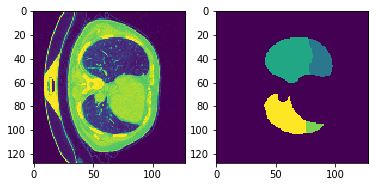

In [168]:
### resize by NN interpolation

import SimpleITK as sitk
data_param =  {'image': {'path_to_search': '/data/weiwei/norm_nii/',
                        'filename_contains': '.intermediate.origVol',
                           'interp_order' : 0,
                           'spatial_window_size': (128, 128, 128)},
                 'label': {'path_to_search': '/data/weiwei/lobe_label_withLungMaskCoord/',
                        'filename_contains': '_label',
                          'interp_order' : 0,
                          'spatial_window_size': (128, 128, 128)}}

reader = ImageReader().initialise(data_param)
window_sizes = {'image': (128, 128, 128), 'label': (128, 128, 128)}
    
# resize sampler returns windows of 32^3-voxels
resize_sampler = ResizeSampler(reader, window_sizes, batch_size=3)

import tensorflow as tf
# adding the tensorflow tensors
next_window = resize_sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    resize_sampler.run_threads(sess) #initialise the iterator
    windows = sess.run(next_window)
    print(windows['image_location'], windows['image'].shape)
    print(windows['label_location'], windows['label'].shape)


import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(windows['image'][1,:,:,50,0])
plt.subplot(1,2,2)
plt.imshow(windows['label'][1,:,:,50,0])
plt.show()
    

nii = windows['image'][0,:,:,:,0]
mask = windows['label'][0,:,:,:,0]

t_nii = np.swapaxes(nii, 0, 2)  #change z axis and x axis
t_mask = np.swapaxes(mask, 0, 2)
t_nii_out = t_nii[:,::-1,:]
t_mask_out = t_mask[:,::-1,:]
image_out = sitk.GetImageFromArray(t_nii_out)
mask_out = sitk.GetImageFromArray(t_mask_out)
sitk.WriteImage(image_out,  '/mnt/Data03/User/weiwei/lung_segments_classification/augmentation_interpolation_example/20151228001310_img_interpNN_downsize128.nii')
sitk.WriteImage(mask_out,  '/mnt/Data03/User/weiwei/lung_segments_classification/augmentation_interpolation_example/20151228001310_label_interpNN_downsize128.nii')


## Using ImageReader with `tf.data.Dataset`

In [ ]:
import tensorflow as tf
from niftynet.io.image_reader import ImageReader

# initialise multi-modal image and label reader
data_param = {'T1':    {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'T1', 'filename_not_contains': 'T1c'},
              'T1c':   {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'T1c'},
              'T2':    {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'T2'},
              'Flair': {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'Flair'},
              'label': {'path_to_search': '~/niftynet/data/BRATS_examples/HGG',
                        'filename_contains': 'Label'}}

grouping_param = {'image': ('T1', 'T1c', 'T2', 'Flair'), 'label':('label',)}
reader = ImageReader().initialise(data_param, grouping_param)

# reader as a generator
def image_label_pair_generator():
    """
    A generator wrapper of an initialised reader.
    
    :yield: a dictionary of images (numpy arrays).
    """
    while True:
        _, image_data, _ = reader()
        yield image_data

# tensorflow dataset
dataset = tf.data.Dataset.from_generator(
    image_label_pair_generator,
    output_types=reader.tf_dtypes)
    #output_shapes=reader.shapes)
dataset = dataset.batch(1)
iterator = dataset.make_initializable_iterator()

# run the tensorlfow graph
with tf.Session() as sess:
    sess.run(iterator.initializer)
    for _ in range(3):
        data_dict = sess.run(iterator.get_next())
        print(data_dict.keys())
        print('image: {}, label: {}'.format(
            data_dict['image'].shape,
            data_dict['label'].shape))